**EIE558 Speech Recognition Lab (Part 2): Continouse Speech Recognition**
This lab assumes that you have already done Part 1 (digitrec.ipynb) and download the speech data to the "data/" folder. We will use Python's SpeechRecognition library (which connects to Google Speech Services) to perform continuous speech recognition. The code shows the procedure for incorporating speech recognition into a Python application.

<font color="red"> This Colab file should be run under Chrome</font>

<font color="green">*Step 1: Prepare Environment*<font>

In [44]:
# Make sure that GPU will be used by clicking "Edit" --> "Notebook Setting"
!pip install SpeechRecognition
!pip install ffmpeg-python
!pip install Levenshtein
# Installing torchaudio 0.5 will automatically install torch 1.5.0
!pip3 install torchaudio==0.5

     |████████████████████████████████| 3.2 MB 4.4 MB/s 
     |████████████████████████████████| 752.0 MB 10 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.5.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.5.0 which is incompatible.


In [46]:
# Make sure that packages "speech_recognition", "ffmpeg", and "Levenshtein" have been installed
import speech_recognition
import ffmpeg
import Levenshtein
import torch, torchaudio
print(torch.__version__)
print(torchaudio.__version__)

1.5.0
0.5.0


In [47]:
# If you use Colab, run this cell to mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Learning/EIE558/asr

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Learning/EIE558/asr


<font color="green">*Step 2: Define functions for speech recognition and computing word error rate*<font>

In [48]:
import Levenshtein as Lev
def edit_distance(s1, s2):
    """
    Computes the edit distance between wo sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """
    s1 = s1.lower()
    s2 = s2.lower()
    
    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein packages only accepts
    # strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))

In [49]:
import speech_recognition as sr
import glob
import os

def speech_to_text(sphfile, ambient_period=0):
    r = sr.Recognizer()
    audiofile = sr.AudioFile(sphfile)
    with audiofile as source:
        r.adjust_for_ambient_noise(source, duration=ambient_period)
        speech = r.record(source)
        return(r.recognize_google(speech))

def get_target1(tranfile, key):
    with open(tranfile) as f:
        for line in f:
            fields = line.split(sep=' ', maxsplit=1)
            if key == fields[0]:
                return fields[-1].rstrip()

def get_target2(tranfile):
    with open(tranfile) as f:
        return(f.readline().split(sep=' ', maxsplit=2)[-1].rstrip())
        

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def plot_speech(audio, srate=16000):
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,10))
    time = np.arange(audio.shape[0])/srate
    ax1.plot(time, audio)
    ax1.set_xlim([0, time[-1]])
    ax2.specgram(audio, NFFT=512, Fs=srate, noverlap=128)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')

In [51]:
from scipy.io import wavfile
import numpy as np

def add_gaussian_noise(input_wav, output_wav, noise_std):
    clean_speech, srate = sf.read(input_wav)
    mu = np.mean(clean_speech)
    sigma = np.std(clean_speech)
    clean_speech = (clean_speech - mu)/sigma
    noise = np.random.normal(0, noise_std, clean_speech.shape[0])
    noisy_speech = np.asarray((clean_speech + noise)*3000, dtype=np.int16)
    wavfile.write(output_wav, srate, noisy_speech)
    return noisy_speech

In [52]:
# Javascript for recording speech from Chrome. 
# Source: https://ricardodeazambuja.com/deep_learning/2019/03/09/audio_and_video_google_colab/
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 16000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

<font color="green">*Step 3: Perform speech recognition*</font>

In [53]:
# Make sure that you are under "./asr" folder.
!pwd

/content/drive/MyDrive/Learning/EIE558/asr


In [54]:
!mkdir -p google-asr
%cd google-asr

/content/drive/MyDrive/Learning/EIE558/asr/google-asr


In [55]:
!pwd

/content/drive/MyDrive/Learning/EIE558/asr/google-asr


In [56]:
# Speech recognition on the .wav files in python-asr/data/speech/
import numpy as np
filelist = glob.glob('../python-asr/data/speech/*.wav', recursive=False)
e_dist = []
n_words = []
for file in filelist:
    rec_text = speech_to_text(file)
    tranfile = file.replace('.wav', '.txt').replace('/speech/','/text/')
    tgt_text = get_target2(tranfile).replace('.', '').replace('?','').replace('!','')
    e_dist.append(edit_distance(rec_text, tgt_text))
    n_words.append(len(tgt_text.split()))
    print(f"Target: {tgt_text.lower()}")
    print(f"Result: {rec_text.lower()}\n")
wer = np.sum(e_dist)/np.sum(n_words) * 100
print("WER = %.2f%%" % wer)

Target: who took the kayak down the bayou
Result: who took the kayak down to buy you

Target: the legislature met to judge the state of public education
Result: the legislature meant to judge the state of public education

WER = 23.53%


In [57]:
# Speech recognition on the .flac files in python-asr/data/speech/
filelist = glob.glob('../python-asr/data/speech/*.flac', recursive=False)
tranfile = "../python-asr/data/text/1272-128104.trans.txt"
e_dist = []
n_words = []
for file in filelist:
    base = os.path.basename(file)
    key = base.replace('.flac', '')
    rec_text = speech_to_text(file)
    tgt_text = get_target1(tranfile, key).replace('.', '').replace('?','').replace('!','')
    e_dist.append(edit_distance(rec_text, tgt_text))
    n_words.append(len(tgt_text.split()))
    print(f"Target: {tgt_text.lower()}")
    print(f"Result: {rec_text.lower()}\n")
wer = np.sum(e_dist)/np.sum(n_words) * 100
print("WER = %.2f%%" % wer)

Target: linnell's pictures are a sort of up guards and at em paintings and mason's exquisite idylls are as national as a jingo poem mister birket foster's landscapes smile at one much in the same way that mister carker used to flash his teeth and mister john collier gives his sitter a cheerful slap on the back before he says like a shampooer in a turkish bath next man
Result: lynelle's pictures are a sort of up guards and adam paintings and masons exquisite italy national as a jingle poem mr. burke foster's landscapes smile at 1 much in the same way that mr. carker used to flashes teeth and mr. john collier gives his sitter a cheerful slapping the back before he says like a shampooer in a turkish bath next man

Target: he tells us that at this festive season of the year with christmas and roast beef looming before us similes drawn from eating and its results occur most readily to the mind
Result: he tells us that at this festive season of the year with christmas and roast beef looming 

<font color="green">*Step 4: Record and recognize your speech*</font>

Please say: Speech recognition is fun


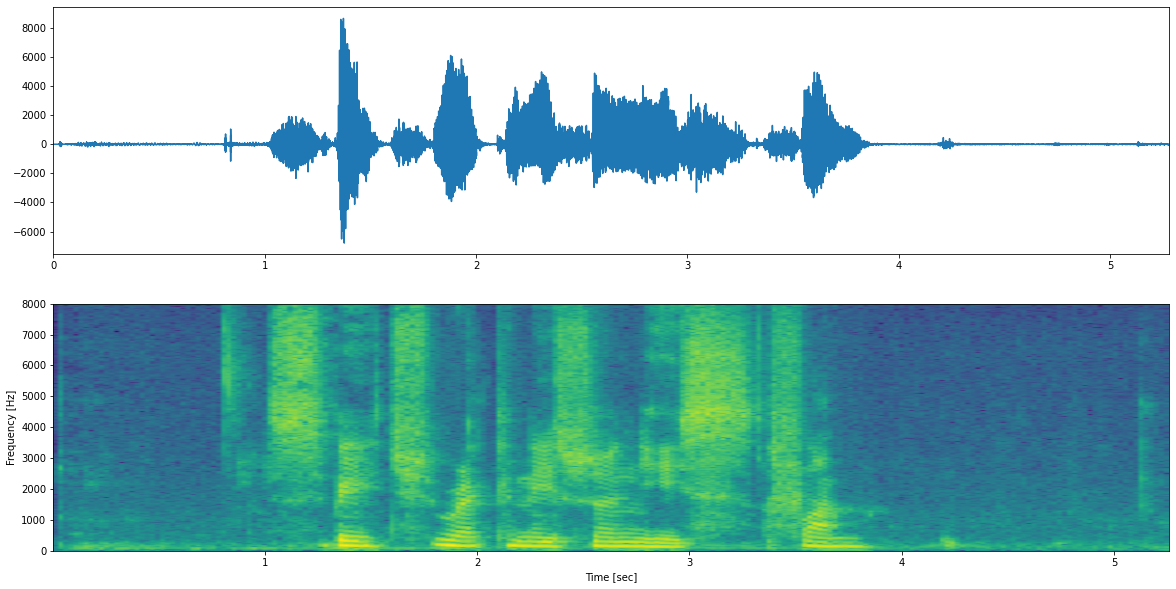

In [58]:
import scipy.signal as sps
from scipy.io import wavfile
tgt_text = "Speech recognition is fun"
print(f"Please say: {tgt_text}")
audio, srate = get_audio()
n_samples = round(len(audio) * float(16000) / srate)
audio = sps.resample(audio, n_samples)
srate = 16000
wavfile.write("./test_clean.wav", srate, audio.astype(np.int16))
plot_speech(audio)

In [59]:
rec_text = speech_to_text("./test_clean.wav")
wer = edit_distance(tgt_text, rec_text)/len(tgt_text.split()) * 100
print(f"Target: {tgt_text.lower()}")
print(f"Result: {rec_text.lower()}")
print("WER = %.2f%%" % wer)

Target: speech recognition is fun
Result: speech recognition is fun
WER = 0.00%


<font color="green">*Step 5: Add noise to the recorded speech and recognize the noisy speech*</font>

In [60]:
# Make sure you are in the 'asr/google-asr' folder
!pwd

/content/drive/MyDrive/Learning/EIE558/asr/google-asr


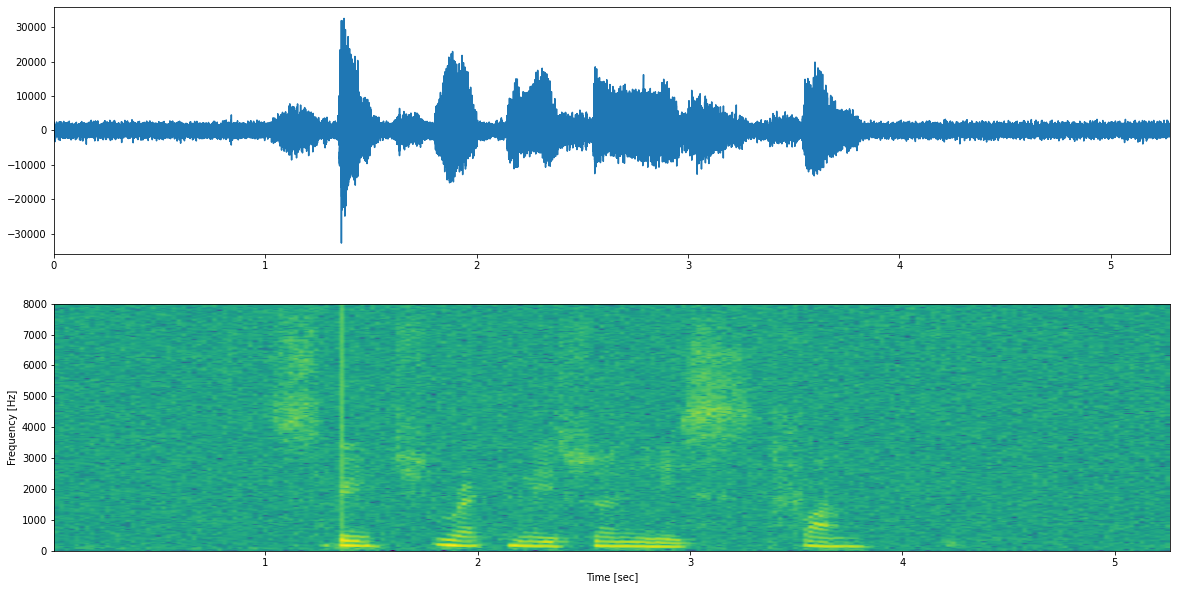

In [61]:
import soundfile as sf
noisy_speech = add_gaussian_noise(input_wav='./test_clean.wav', output_wav='./test_noisy.wav', noise_std=0.3)
plot_speech(noisy_speech)

In [62]:
from IPython.display import Audio
Audio(noisy_speech, rate=srate)

In [63]:
rec_text = speech_to_text("./test_noisy.wav", ambient_period=0)
wer = edit_distance(tgt_text, rec_text)/len(tgt_text.split()) * 100
print(f"Target: {tgt_text.lower()}")
print(f"Result: {rec_text.lower()}")
print("WER = %.2f%%" % wer)

Target: speech recognition is fun
Result: speech recognition nice fun
WER = 25.00%


<font color="green">*Step 6: Use DC-Unet to denoise the noisy speech and recognize the denoised speech*</font>

In [64]:
# Make sure that the file 'dc-unet_test.py' is in your Google Drive
!ls /content/drive/MyDrive/Learning/EIE558/DCUnet16/dc-unet_test.py

/content/drive/MyDrive/Learning/EIE558/DCUnet16/dc-unet_test.py


In [65]:
%cd "/content/drive/MyDrive/Learning/EIE558/DCUnet16"
!python3 dc-unet_test.py --noised_wav ../asr/google-asr/test_noisy.wav \
                          --denoised_wav ../asr/google-asr/test_denoised.wav

/content/drive/MyDrive/Learning/EIE558/DCUnet16
Test mode
<Figure size 640x480 with 1 Axes>
<Figure size 640x480 with 1 Axes>
<Figure size 640x480 with 1 Axes>
<Figure size 640x480 with 1 Axes>


In [66]:
%cd "/content/drive/MyDrive/Learning/EIE558/asr/google-asr"

/content/drive/MyDrive/Learning/EIE558/asr/google-asr


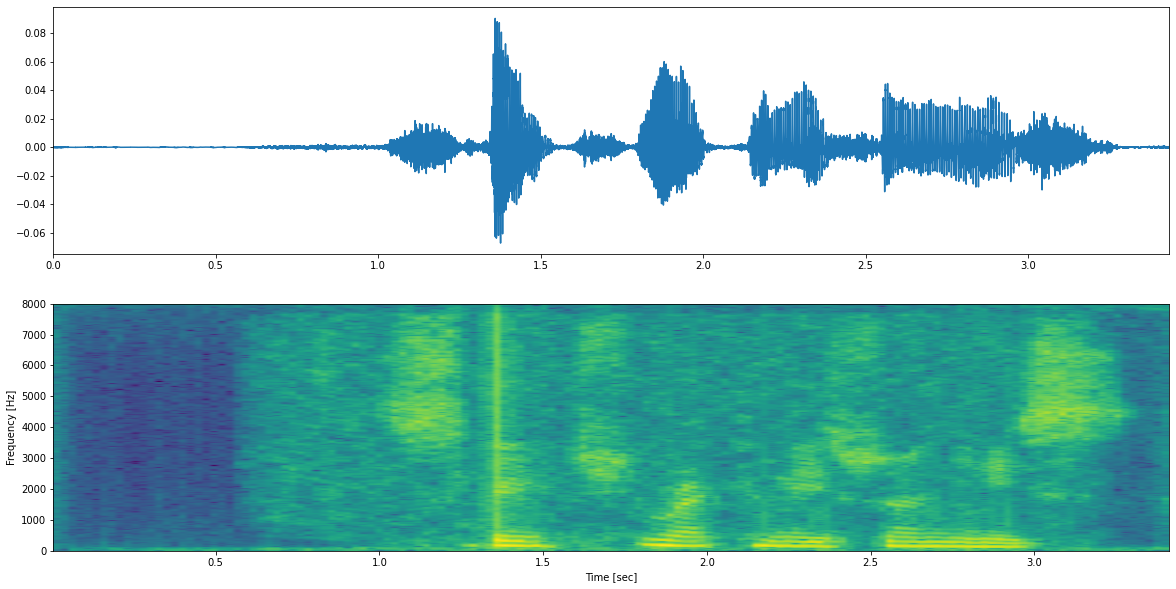

In [67]:
# Plot denoised speech
import soundfile as sf
from scipy.io import wavfile
denoised_speech, srate = sf.read('./test_denoised.wav')
plot_speech(denoised_speech)

In [68]:
from IPython.display import Audio
Audio(denoised_speech, rate=srate)

In [69]:
rec_text = speech_to_text("./test_denoised.wav")
wer = edit_distance(tgt_text, rec_text)/len(tgt_text.split()) * 100
print(f"Target: {tgt_text.lower()}")
print(f"Result: {rec_text.lower()}")
print("WER = %.2f%%" % wer)

Target: speech recognition is fun
Result: speech recognition release
WER = 50.00%


<font color="green">*Step 7: Add noise to the .flac files in "data/speech/" at different noise level (defined by the variable "noise_std" in the add_gaussian_noise() function). Perform speech recognition on the noisy speech. Report the word error rate at different noise level.*</font> <font color="red">*To reduce the workload of this subject, this step is OPTIONAL, i.e., your report does not need to include this step.*</font>